In [27]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np

import os
import wandb
from wandb.keras import WandbCallback
from PIL import Image
from keras.callbacks import ReduceLROnPlateau

In [28]:
run = wandb.init(project="Distillation", tensorboard=True)
config = run.config
config.dropout = 0.25
config.dense_layer_nodes = 100
config.learn_rate = 0.32  #0.01 
config.batch_size = 1024  #32
config.epochs = 100


W&B Run: https://app.wandb.ai/qualcomm/Distillation/runs/jx4egmee
Call `%%wandb` in the cell containing your training loop to display live results.


In [29]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
num_classes = len(class_names)

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Normalize values into [0 to 1] because all default assume zero to one
# We won't bother to fully sphere the data, removing median and divide by variance
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


In [22]:
X_train.shape

(50000, 32, 32, 3)

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

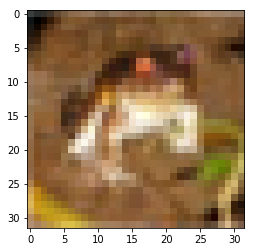

In [30]:
data = X_train[0]
from matplotlib import pyplot as plt
plt.imshow(data, interpolation='nearest')
y_train[0]

In [31]:
# Define Model
# Note: We can set some of these at variables to reduce capacity 
model = Sequential() # Sets up model structure to pass data forward 
model.add(Conv2D(32, # Activation layers 
                 (3, 3), # Conv dim
                 padding='same', # Use padding to maintain same dims
                 input_shape=X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # 16x16 dim per activation
model.add(Conv2D(32, # Activation layers 
                 (3, 3), # Conv dim
                 padding='same', # Use padding to maintain same dims
                 input_shape=X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # 16x16 dim per activation
model.add(Dropout(config.dropout)) # Add a dash of regularization (too taste)

# NOTE: Would be fun to try a 16x16xActivation conv to a 1x1x10 tensor
model.add(Flatten()) # Because dense layers like 1D vectors 
model.add(Dense(config.dense_layer_nodes, activation='relu'))
model.add(Dropout(config.dropout)) # A pinch more regularization 
model.add(Dense(num_classes, activation='softmax')) # Plate and serve

# NOTE: Could also try Adam at some point
opt = keras.optimizers.SGD(lr=config.learn_rate) # No momentum 

model.compile(loss='categorical_crossentropy', # Because one hot encoding
              optimizer=opt, # Per previous decision to not use momentum
              metrics=['accuracy']) # Easier to look at than cross entropy

# Data augmentation to improve performance on the dataset 
# datagen = ImageDataGenerator(width_shift_range=0.1)
# datagen.fit(X_train)

In [8]:
# Fit the model on the batches generated by datagen.flow
# For batch size make sure it's big enough to leverage GPU parallelism 
#    As a basic rule you need to reduce learning rate as you reduce batch size
# NOTE: Will be interesting to optimize for training time a bit by tweaking batch size
"""
model.fit_generator(datagen.flow( # Slightly clever, operate over datagen not X_train
                            X_train, y_train,
                            batch_size=config.batch_size),
                        # Define an epoch as a single full pass over the data
                        steps_per_epoch=X_train.shape[0] // config.batch_size,
                        # Will use a fixed set of epochs rather than a stopping criteria 
                        epochs=config.epochs,
                        validation_data=(X_test, y_test),
                        # Allow multiple CPUs to help with data augmentation to avoid GPU starvation
                        workers=4,
                        # Make sure we can see the pastries while they bake
                        callbacks=[WandbCallback(data_type="image", labels=class_names)]
)
"""

'\nmodel.fit_generator(datagen.flow( # Slightly clever, operate over datagen not X_train\n                            X_train, y_train,\n                            batch_size=config.batch_size),\n                        # Define an epoch as a single full pass over the data\n                        steps_per_epoch=X_train.shape[0] // config.batch_size,\n                        # Will use a fixed set of epochs rather than a stopping criteria \n                        epochs=config.epochs,\n                        validation_data=(X_test, y_test),\n                        # Allow multiple CPUs to help with data augmentation to avoid GPU starvation\n                        workers=4,\n                        # Make sure we can see the pastries while they bake\n                        callbacks=[WandbCallback(data_type="image", labels=class_names)]\n)\n'

In [24]:
# Model 
# For batch size make sure it's big enough to leverage GPU parallelism 
#    As a basic rule you need to reduce learning rate as you reduce batch size
# NOTE: Will be interesting to optimize for training time a bit by tweaking batch size
model.fit(
        X_train, 
        y_train,
        batch_size=config.batch_size,
        # Will use a fixed set of epochs rather than a stopping criteria 
        epochs=10,
        validation_data=(X_test, y_test),
        # Make sure we can see the pastries while they bake
        callbacks=[
            WandbCallback(data_type="image", labels=class_names),
            ReduceLROnPlateau(min_delta=0.005, patience=2)
        ]
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
17408/50000 [=========>....................] - ETA: 2s - loss: 2.2843 - acc: 0.1350

KeyboardInterrupt: 

In [2]:
import keras
model2 = keras.models.load_model("lukas.h5")

Using TensorFlow backend.


In [25]:
model.load("lukas.h5")
y_train_softmax_output = model.predict(X_train)

In [32]:
np.max(y_train_softmax_output[0:100],axis=1)

array([0.11243107, 0.1364868 , 0.15628915, 0.10892259, 0.14030083,
       0.1247833 , 0.12732808, 0.12384515, 0.14750944, 0.1317587 ,
       0.10844875, 0.15017726, 0.14847837, 0.11087765, 0.1282176 ,
       0.14528564, 0.15323119, 0.10904116, 0.1392558 , 0.12710227,
       0.13575622, 0.11835162, 0.10903669, 0.11636707, 0.12693058,
       0.13882244, 0.12526631, 0.11442906, 0.12645176, 0.15872791,
       0.12552166, 0.14409621, 0.12742051, 0.11733045, 0.12378559,
       0.13244353, 0.13158296, 0.12182778, 0.1401626 , 0.1192603 ,
       0.13357589, 0.13806371, 0.12602587, 0.13406932, 0.13030203,
       0.11403947, 0.12394032, 0.11842299, 0.1312151 , 0.15390234,
       0.11645106, 0.13566191, 0.1114352 , 0.1435345 , 0.10805386,
       0.14622363, 0.11419181, 0.11241594, 0.11480045, 0.15236506,
       0.13779368, 0.13385184, 0.12789743, 0.11902445, 0.12393956,
       0.13454428, 0.11301883, 0.15417528, 0.12719199, 0.13148233,
       0.12110427, 0.13435772, 0.13657553, 0.12534186, 0.12440

In [26]:
np.save("y_train_softmax_output", y_train_softmax_output)

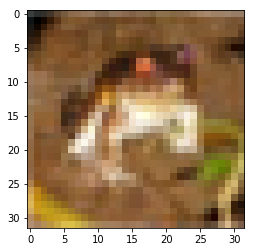

In [11]:
data = X_train[0]
from matplotlib import pyplot as plt
plt.imshow(data, interpolation='nearest')
plt.show()

(array([2540., 7803., 9774., 8806., 7181., 6142., 4797., 2436.,  470.,
          51.]),
 array([0.102368  , 0.10959391, 0.11681981, 0.12404573, 0.13127163,
        0.13849755, 0.14572346, 0.15294936, 0.16017528, 0.16740118,
        0.1746271 ], dtype=float32),
 <a list of 10 Patch objects>)

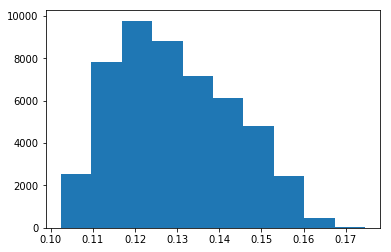

In [33]:
maxes = np.max(y_train_softmax_output,axis=1)
plt.hist(maxes)